## <center> **Latency Arbitrage**  

This notebook implements a latency arbitrage, identifying significant trades on Binance and executes trades on HyperLiquid based on order book imbalance signals.

### Key Features
1. **Slippage Modeling**
   - Order book walking with latency simulation
   - Transaction cost modeling
   - Dynamic liquidity impact estimation

2. **Statistical Significance Testing**
   - Bootstrap analysis for confidence intervals
   - Power analysis for sample size estimation

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import logging
from collections import defaultdict
from tqdm import tqdm
from statsmodels.stats.power import TTestPower
from scipy import stats
import matplotlib.dates as mdates
from scipy.stats import ttest_1samp
from typing import List, Dict, Tuple, Any, Optional, Union

# Auto-reload external module changes without restarting
%load_ext autoreload
%autoreload 2

# Import our code
import data_loader as dl
import utils as ref

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# For cleaner pandas output
pd.set_option('expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Strategy Overview

The idea is that large trades on Binance may cause short-term price changes that propagate to HyperLiquid. By detecting these "significant trades" quickly, we can enter positions on HyperLiquid, factoring in order book imbalance for additional confirmation, and exit once we achieve a certain profit threshold relative to fees.

- We define *significant* trades on Binance as those above a very high
  volume, to capture only the largest moves.
- On HyperLiquid, we watch the order book imbalance at the time we get
  the signal. If it supports going long, we take a buy position; if it supports going
  short, we take a sell position.
- The backtest simulates realistic conditions, including:
     * Slippage from walking the order book
     * Latency, which reduces available liquidity
     * Taker/maker fees
     * A maximum holding period, after which we exit regardless

The code also includes statistical significance tests, such as:
 - Bootstrap for confidence intervals
 - Power analysis to estimate how many trades we need to achieve significance

In [2]:
# Parameters for data retrieval
SYMBOL = 'OMNI'
START_MONTH = 5
END_MONTH = 12
YEAR = 2024

In [4]:
# Load Binance trades (signal data)
binance_trades = dl.load_binance_trades_monthly(
    SYMBOL, 
    YEAR, 
    START_MONTH, 
    END_MONTH,
    file_extension='parquet'
)

2025-04-14 12:54:51,223 - INFO - Loading Binance trades from cache: cache/binance_OMNI_2024_5_12.pkl


In [126]:
# Load Binance trades (signal data)
binance_trades = dl.load_binance_trades_monthly(
    SYMBOL, 
    YEAR, 
    START_MONTH, 
    END_MONTH
)

# Load processed LOB data for HyperLiquid (target data)
hl_book_resampled = dl.load_minimal_lob_data(SYMBOL, year=2024, start_month=START_MONTH, end_month=END_MONTH, base_path='./data/processed_lob_data')

print(f"Binance trades shape: {binance_trades.shape}")
print(f"LOB data shape: {hl_book_resampled.shape}")

# Display small sample
print("\nBinance trades sample:")
print(binance_trades.head())

print("\nLOB data sample:")
print(hl_book_resampled)

2025-04-14 18:20:43,427 - INFO - Loading Binance trades from cache: cache/binance_OMNI_2024_5_12.pkl
2025-04-14 18:20:43,559 - INFO - Loading monthly LOB file (1/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202405.parquet.gz
2025-04-14 18:20:43,970 - INFO - Loading monthly LOB file (2/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202406.parquet.gz
2025-04-14 18:20:44,382 - INFO - Loading monthly LOB file (3/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202407.parquet.gz
2025-04-14 18:20:45,287 - INFO - Loading monthly LOB file (4/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202408.parquet.gz
2025-04-14 18:20:45,846 - INFO - Loading monthly LOB file (5/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202409.parquet.gz
2025-04-14 18:20:46,274 - INFO - Loading monthly LOB file (6/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202410.parquet.gz
2025-04-14 18:20:46,558 - INFO - Loading monthly LOB file (7/8): ./data/processed_lob_data\OMNI\OMNI_LOB_202411.parquet.gz
2025-04-14 18:20:46,939 - INFO - Loadi

Binance trades shape: (4632653, 6)
LOB data shape: (34635289, 7)

Binance trades sample:
                         trade_id  price    qty  quote_qty  is_buyer_maker  is_best_match
timestamp                                                                                
2024-05-01 00:00:19.244   2676173  18.29   0.39     7.1331           False           True
2024-05-01 00:00:25.779   2676185  18.26  35.27   644.0302            True           True
2024-05-01 00:00:25.784   2676188  18.28   1.31    23.9468           False           True
2024-05-01 00:00:25.785   2676189  18.28   1.31    23.9468           False           True
2024-05-01 00:00:25.790   2676190  18.27   1.31    23.9337           False           True

LOB data sample:
                         BidPrice_1   BidSize_1  AskPrice_1   AskSize_1   MidPrice  Imbalance  Microprice
time                                                                                                     
2024-05-01 00:00:06.441   18.292999  186.630005    

### **Significant Trade Identification and Alignment**

- Filter down to a relevant time range on Binance
- Identify trades above a certain quantile threshold
- Align these "significant trades" to the nearest HyperLiquid LOB snapshot, applying a time offset

In [ ]:
# Filter Binance trades to our target date range
if not binance_trades.empty:
    start_t = pd.Timestamp('2024-05-01')
    end_t = pd.Timestamp('2024-12-20 23:59:59')
    binance_trades_rs = binance_trades.loc[start_t:end_t]

    # We now show how to use rolling threshold
    sig_trades = dl.identify_significant_trades(
       binance_trades_rs, use_rolling_threshold=True, rolling_window='7d', rolling_multiplier=25.0
    )
else:
    sig_trades = pd.DataFrame()

# Align trades with LOB snapshots
if not sig_trades.empty and not hl_book_resampled.empty:
    sig_trades_aligned = dl.align_trades_to_lob(sig_trades, hl_book_resampled, time_offset_ms=20)
else:
    sig_trades_aligned = pd.DataFrame()

print(f"Number of significant trades identified: {len(sig_trades)}")
print(f"Number of significant trades aligned to LOB: {len(sig_trades_aligned)}")
    

print(f"Number of significant trades identified: {len(sig_trades)}")
print(f"Number of significant trades aligned to LOB: {len(sig_trades_aligned)}")

2025-04-14 18:29:35,720 - INFO - Identified 1254 significant trades via rolling threshold approach.
2025-04-14 18:29:35,749 - INFO - Aligned 1254 trades to LOB snapshots
2025-04-14 18:29:35,750 - INFO - Cached aligned trades to: cache/aligned_trades_8363325761213263708.pkl


Number of significant trades identified: 1254
Number of significant trades aligned to LOB: 1254
Number of significant trades identified: 1254
Number of significant trades aligned to LOB: 1254


## <center> **Backtest**

We configure base parameters for the backtest, including fees, size constraints, maximum holding, slippage settings, etc. Then we run the backtest on our aligned trades and examine the performance metrics.

Running backtest...


--- Backtest Summary ---
Total Profit: 323.9253
Successful Trades: 128
Failed Trades: 7
Win Rate: 94.81%
Skipped: 1112
Avg Entry Slippage: 0
Avg Exit Slippage: 0
Avg Profit Per Trade: 2.3994
Profit Std Dev: 5.3314
Max Profit: 55.0959
Min Profit: -0.9756
Total Trades: 135
Max Drawdown: 0.0001
Sharpe Ratio: 0.4501
Annualized Sharpe: 6.5755
Sortino Ratio: 9.5959


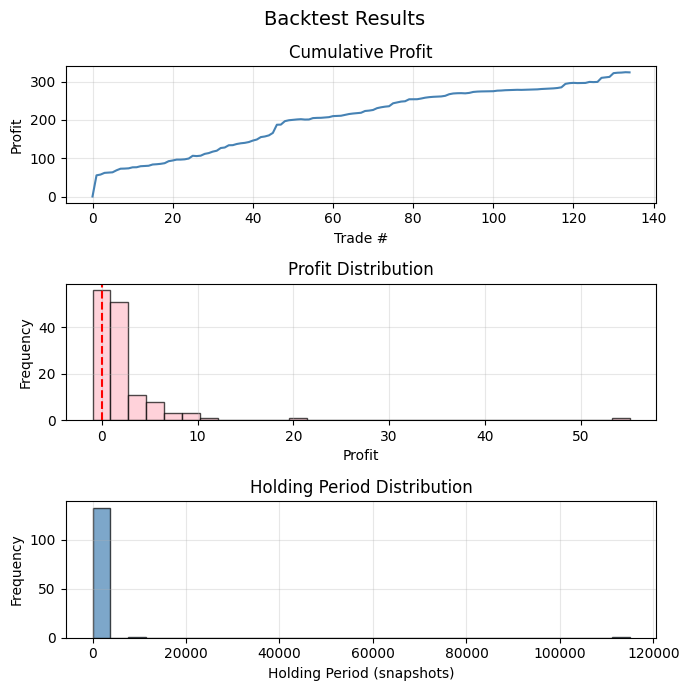

In [146]:
base_params = {
    'taker_fee': 0.00019,
    'maker_fee': 0.00000,
    'fee_multiple': 2,
    'capital': 10_000,
    'min_size': 10,
    'max_size': 100,
    'imb_threshold_long': -0.70,
    'imb_threshold_short': 0.70,
    'use_microprice': True,
    'use_trailing_stop': True,
    'trailing_activation_bps': 2,
    'trailing_distance_bps': 5,
    'max_risk_pct': 0.50,
    'simulate_slippage': True,
    'slippage_factor': 1.0,
    'mean_latency_ms': 50,
    'std_dev_latency_ms': 10
}

if not sig_trades_aligned.empty and not hl_book_resampled.empty:
    print("Running backtest...\n")
    
    summary_with_slippage, results = ref.backtest(
        sig_trades_aligned,
        hl_book_resampled,
        **base_params
    )
    
    # Print the summary metrics
    print("\n--- Backtest Summary ---")
    for k, v in summary_with_slippage.items():
        if k == 'Win Rate':
            print(f"{k}: {v:.2%}")
        elif isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")
    
    # If we have trade-by-trade data, create a results DataFrame and plot
    if results:
        df_results_with = pd.DataFrame(results)
        df_results_with['cumulative_profit'] = df_results_with['profit'].cumsum()
        
        # Plot the results: cumulative PnL, distribution of trades, etc.
        ref.plot_results(df_results_with)
        
        # Also store returns = profit / capital
        df_results_with['return'] = df_results_with['profit'] / base_params['capital']
else:
    print("Insufficient data for a backtest.")

### <center> **Statistical Significance Analysis**

We use
- A block bootstrap to estimate confidence intervals for mean returns
- A power analysis to see how many trades are needed to achieve significance

In [144]:
# Assuming that the backtest produced a trade-by-trade DataFrame named df_results_with:
if 'df_results_with' in locals() and not df_results_with.empty:
    # Compute per-trade profit returns (profit divided by starting capital)
    returns = df_results_with['profit'].values
    capital_used = base_params['capital']  # Ensure base_params is defined (as in the code above)
    
    # Call the statistical test function
    signal_test = ref.check_signal_significance(returns, capital=capital_used, alpha=0.05)
    
    print("\n--- Signal Significance Test ---")
    print(f"Sample Size (number of trades): {signal_test['sample_size']}")
    print(f"Mean Return: {signal_test['mean_return']:.6f}")
    print(f"Standard Deviation of Returns: {signal_test['std_return']:.6f}")
    print(f"T-statistic: {signal_test['t_statistic']:.4f}")
    print(f"One-sided P-value: {signal_test['p_value']:.4f}")
    
    if signal_test['significant']:
        print("Signal is statistically significant and actionable.")
    else:
        print("No statistically significant signal found.")
else:
    print("No trade results available for significance testing.")


--- Signal Significance Test ---
Sample Size (number of trades): 135
Mean Return: 0.000024
Standard Deviation of Returns: 0.000053
T-statistic: 5.2292
One-sided P-value: 0.0000
Signal is statistically significant and actionable.



--- Bootstrap Analysis ---
Mean Return: 0.000024
95% Confidence Interval: [0.000016, 0.000030]


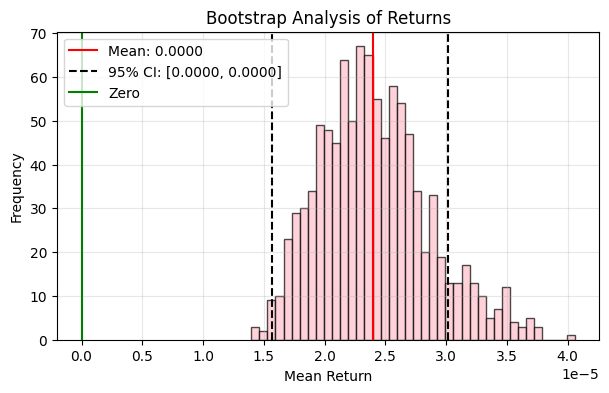

Required Sample Size for 80% Power: 41 trades
Current Sample: 135 trades (100.0% of required)


In [145]:
if 'df_results_with' in locals() and not df_results_with.empty:
    returns = df_results_with['return'].values
    
    # 1) Bootstrap analysis
    mean_return, conf_interval = ref.bootstrap_returns(returns, iterations=10_000)
    
    print("\n--- Bootstrap Analysis ---")
    print(f"Mean Return: {mean_return:.6f}")
    print(f"95% Confidence Interval: [{conf_interval[0]:.6f}, {conf_interval[1]:.6f}]")
    
    ref.plot_bootstrap_analysis(
        returns,
        bootstrap_mean=mean_return,
        conf_interval=conf_interval,
        title="Bootstrap Analysis of Returns"
    )
    
    # 2) Power analysis
    required_sample = ref.calculate_power_sample_size(returns)
    print(f"Required Sample Size for 80% Power: {required_sample:.0f} trades")
    if np.isfinite(required_sample):
        current_percentage = (len(returns) / required_sample) * 100
        current_percentage = min(current_percentage, 100)
        print(f"Current Sample: {len(returns)} trades ({current_percentage:.1f}% of required)")
    else:
        print("Insufficient or invalid data for a power calculation.")